In [8]:
# Data
import numpy as np

with open('data/text_data/japan.txt', 'r') as f:
    txt = f.read()

    X = []
    y = []

    char_to_idx = {char: i for i, char in enumerate(set(txt))}
    idx_to_char = {i: char for i, char in enumerate(set(txt))}

    X = np.array([char_to_idx[x] for x in txt])
    y = [char_to_idx[x] for x in txt[1:]]
    y.append(char_to_idx['.'])
    y = np.array(y)

In [19]:
# Model or Network
import impl.layer as l

class GRU:
    def __init__(self, D, H, L, char2idx, idx2char):
        self.D = D
        self.H = H
        self.L = L
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'smooth train':[]}
        
        # Model params
        Z = H + D
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wr=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.),
            bz=np.zeros((1, H)),
            br=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )

        self.model = []
        for layer in range(self.L):
            self.model.append(m)

    def initial_state(self):
        return np.zeros((1, self.H))

    def forward(self, X, h, m):
        Wz, Wr, Wh, Wy = m['Wz'], m['Wr'], m['Wh'], m['Wy']
        bz, br, bh, by = m['bz'], m['br'], m['bh'], m['by']

        X_one_hot = X.copy()
        h_old = h.copy()

        X = np.column_stack((h_old, X_one_hot))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        hr, hr_cache = l.fc_forward(X, Wr, br)
        hr, hr_sigm_cache = l.sigmoid_forward(hr)

        X_prime = np.column_stack((hr * h_old, X_one_hot))
        hh, hh_cache = l.fc_forward(X_prime, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        h = (1. - hz) * h_old + hz * hh

        y, y_cache = l.fc_forward(h, Wy, by)

        cache = (
            X, X_prime, h_old, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache,
            hh, hh_cache, hh_tanh_cache, h, y_cache
        )

        return y, h, cache

    def backward(self, dy, dh, cache):
        X, X_prime, h_old, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, h, y_cache = cache
        
        dh_next = dh.copy()

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_next

        dhh = hz * dh
        dh_old1 = (1. - hz) * dh
        dhz = hh * dh - h_old * dh

        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dX_prime, dWh, dbh = l.fc_backward(dhh, hh_cache)

        dh_prime = dX_prime[:, :self.H]
        dh_old2 = hr * dh_prime

        dhr = h_old * dh_prime
        dhr = l.sigmoid_backward(dhr, hr_sigm_cache)
        dXr, dWr, dbr = l.fc_backward(dhr, hr_cache)

        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXr + dXz
        dh_old3 = dX[:, :self.H]

        dh = dh_old1 + dh_old2 + dh_old3
        dX = dX[:, self.H:]

        grad = dict(Wz=dWz, Wr=dWr, Wh=dWh, Wy=dWy, bz=dbz, br=dbr, bh=dbh, by=dby)
        
        return dX, dh, grad

    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            caches.append([])

        for X in X_train:
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            y = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], cache = self.forward(y, h[layer], self.model[layer])
                caches[layer].append(cache)
                
            ys.append(y)
            
        return ys, caches

    def cross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        prob = l.softmax(y_pred)
        log_like = -np.log(prob[range(m), y_train])
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        grad_y = l.softmax(y_pred)
        grad_y[range(m), y_train] -= 1.0
        grad_y /= m

        return grad_y
    
    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += self.cross_entropy(y_pred, y)
            dy = self.dcross_entropy(y_pred, y)
            dys.append(dy)
            
        return loss, dys
    
    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for _ in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
        
        for t in reversed(range(len(dys))):
            dX = dys[t]
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[layer] = self.backward(dX, dh[layer], caches[layer][t])
                for k in grad[0].keys():
                    grads[layer][k] += grad[layer][k]
                
        return dX, grads
    
    def test(self, X_seed, h, size):
        chars = [self.idx2char[X_seed]]
        idx_list = list(range(self.vocab_size))
        X = X_seed
        
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())

        for _ in range(size):
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            y = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], _ = self.forward(y, h[layer], self.model[layer])
                
            prob = l.softmax(y)
            idx = np.random.choice(idx_list, p=prob.ravel())
            chars.append(self.idx2char[idx])
            X = idx

        return ''.join(chars)

In [38]:
# Solver, optimizer, or SGD
from sklearn.utils import shuffle as skshuffle

def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    if shuffle:
        X, y = skshuffle(X, y)

    for i in range(0, X.shape[0], minibatch_size):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, y_train, alpha, mb_size, n_iter, print_after):
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)

    M, R = [], []
    for _ in range(nn.L):
        M.append({k: np.zeros_like(v) for k, v in nn.model[0].items()})
        R.append({k: np.zeros_like(v) for k, v in nn.model[0].items()})
        
    beta1 = .9
    beta2 = .999
    idx = 0
    state = nn.initial_state()
    smooth_loss = 1 # -np.log(1.0 / len(set(X_train)))
    eps = 1e-8
    
    for iter in range(1, n_iter + 1):

        if idx >= len(minibatches):
            idx = 0
            state = nn.initial_state()
        X_mini, y_mini = minibatches[idx]
        idx += 1

        ys, caches = nn.train_forward(X_mini, state)
        loss, dys = nn.loss_function(y_mini, ys)
        dX, grads = nn.train_backward(dys, caches)
        smooth_loss = 0.999 * smooth_loss + 0.001 * loss
        nn.losses['smooth train'].append(smooth_loss)
        nn.losses['train'].append(loss)


        for layer in range(nn.L):
            for k in grads[0].keys(): #key, value: items
                M[layer][k] = l.exp_running_avg(M[layer][k], grads[layer][k], beta1)
                R[layer][k] = l.exp_running_avg(R[layer][k], grads[layer][k]**2, beta2)

                m_k_hat = M[layer][k] / (1. - beta1**(iter))
                r_k_hat = R[layer][k] / (1. - beta2**(iter))

                nn.model[layer][k] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + eps)
                
        # Print loss and test sample
        if iter % print_after == 0:
            print('Iter-{} loss: {:.4f}'.format(iter, loss))
            sample = nn.test(X_mini[0], state, mb_size)
            print(sample)
            
    return nn

In [39]:
# Hyper-parameters
vocab_size = len(char_to_idx)

# hyper parameters
time_step = 100 # width
num_layers = 1 # depth
n_iter = 13000 # epochs
alpha = 1e-3 # learning_rate
print_after = n_iter//10 # print training loss, valid, and test
H = 64 # num_hidden_units in hidden layer

In [40]:
# Build the network and learning it or optimizing it using SGD
net = GRU(D=vocab_size, H=H, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char)

adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

Iter-1300 loss: 171.0497
 the war tarlativurest-ling lipen-lape the Eas and miecolort ramen an hiothx WarcNlarnes lyvink in Ss
Iter-2600 loss: 74.9148
the Srya, "sinsoremtored and inkate of Japan is a of Soaten I forlalita uoustotexiand To;of hiss l pe
Iter-3900 loss: 54.2333
the canly, whre the hish China urminan aban kenbe mellron of Japan's oundlaregis, the G7, the OEy1 by
Iter-5200 loss: 32.8623
rumed Peale aided inte tho of history texts atest on the eap, anoped and aing-Japan (Japanesi: Ta mhl
Iter-6500 loss: 23.2579
maily itgor obal the hist ontat and the world, whicterigld in ant of deconomeint-larlited eif operlag
Iter-7800 loss: 21.7392
 of 168. Japan (I1d Sea and surch sedeat Japan was inhabited as eorliced is anderil Tokuwod peciloced
Iter-9100 loss: 6.4303
ry Brand Index and insthe War, Indexghiad Sunce forld.ight hist inta is the sexta uobtimitan mitila. 
Iter-10400 loss: 5.4428
 Paleolithic errtea of Japan, is ante and Warla. The four larigiw no Sead in the . Japan was t

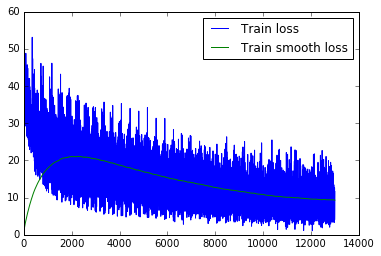

In [35]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()